In [155]:
# Connect to server
#import pyodbc
#from dotenv import dotenv_values

# Datetime
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import missingno as msno

# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Statistical Analysis
import scipy.stats as stats
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.api as sm
from pmdarima.arima import CHTest, nsdiffs
from pmdarima.arima import auto_arima
#from arch.unitroot import ADF, KPSS
from statsmodels.stats.diagnostic import acorr_ljungbox
#import phik
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

# Machine Learning Modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
#import xgboost as xgb
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.pipeline import Pipeline

import os
import gzip, pickle, pickletools

import random

import warnings
import time

# ignore warnings
warnings.filterwarnings('ignore')

from pathlib import Path, PureWindowsPath

In [156]:
#! pip install missingno
#! pip install pmdarima

### Import data

In [157]:
path_cwd = Path(PureWindowsPath(os.path.dirname(os.getcwd())))
path_cwd
path = path_cwd / 'data/processed/'

In [158]:
filepath = path / "df_train.pkl"
with gzip.open(filepath, 'rb') as f:
    p = pickle.Unpickler(f)
    train_data = p.load()

In [159]:
#train_data = pd.read_pickle(path / 'df_train.pkl')
val_data = pd.read_pickle(path / 'df_val.pkl')
test_data = pd.read_pickle(path / 'df_test.pkl')

In [160]:
train_data.shape[0]

1935987

In [161]:
train_data['familycluster'].unique()

array([5, 1, 4, 0, 2, 3], dtype=int64)

In [162]:
val_data['date']

0        2016-04-26
1        2016-04-26
2        2016-04-26
3        2016-04-26
4        2016-04-26
            ...    
276564   2016-10-03
276565   2016-10-03
276566   2016-10-03
276567   2016-10-03
276568   2016-10-03
Name: date, Length: 276569, dtype: datetime64[ns]

## Modeling ##

In [163]:
# Updated plot_predictions to work with dataframes where the date is not already aggregated
# This simply aggregates the dates inside the function
def plot_predictions(date, y_test, y_pred, forecast_label, title):
    """
    Plot the actual and predicted time series data.

    Parameters:
    date (array-like): Date or time index.
    y_test (array-like): Actual values.
    y_pred (array-like): Predicted values.
    forecast_label (str): Label for the forecasted data.
    title (str): Title for the plot.
    """
    # Combine the data into a DataFrame
    data = pd.DataFrame({'Date': date, 'Actual': y_test, 'Predicted': y_pred})
    
    # Aggregate the data by date, taking the mean of the values for each day
    data = data.groupby('Date').mean().reset_index()
    
    # Set the custom color palette
    custom_palette = sns.color_palette("husl", 2)
    sns.set_palette(custom_palette)
    
    # Create a figure with specified dimensions
    plt.figure(figsize=(8, 6))

    # Plot the actual data in green
    sns.lineplot(data=data, x='Date', y='Actual', label='Actual', color=custom_palette[0])

    # Plot the predicted data in blue with the specified label
    sns.lineplot(data=data, x='Date', y='Predicted', label=forecast_label, color=custom_palette[1])

    # Add a legend to the plot
    plt.legend()

    # Set the title of the plot
    plt.title(title)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    plt.ylabel('Daily Sales')
    # Display the plot
    plt.show()

In [164]:
# Define a function to compute the evaluations metrics after the forecast
def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Compute Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, forecast)
    
    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the evaluation metrics as a dictionary
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'RMSLE': rmsle_value
    }
    
    return metrics

In [165]:
# Exogenous variables to help predict sales
#ex_variables = ['onpromotion', 'day_of_week', 'lag_1', 'rolling_mean']
ex_variables = ['onpromotion', 'day_of_week']

## OLS ##

### create dummy variables ###

In [166]:
train_data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'cluster',
       'day_of_week', 'month', 'year', 'oil_price', 'familycluster',
       'holiday_Carnaval', 'holiday_Dia de la Madre',
       'holiday_Dia del Trabajo', 'holiday_Fundacion de Quito',
       'holiday_Independencia de Cuenca',
       'holiday_Mundial de futbol Brasil: Ecuador-Suiza', 'holiday_Navidad-1',
       'holiday_Navidad-2', 'holiday_Navidad-3', 'holiday_Navidad-4',
       'holiday_Primer dia del ano', 'holiday_Terremoto Manabi+1',
       'holiday_Terremoto Manabi+2', 'holiday_Terremoto Manabi+3',
       'holiday_Terremoto Manabi+4', 'holiday_Terremoto Manabi+5',
       'holiday_Traslado Primer dia del ano'],
      dtype='object')

In [167]:
def create_dummy_fam_cluster(df):
    df2 = df.drop(columns=['store_nbr','family','id','date'])
    df2  = pd.get_dummies(df2, columns=['familycluster','cluster']) 
    return df2

def create_dummy(df):
    df2 = df.drop(columns=['store_nbr','familycluster','id','date'])
    df2  = pd.get_dummies(df2, columns=['family','cluster']) 
    return df2


In [168]:
df_train_ols = create_dummy(train_data)
df_val_ols = create_dummy(val_data)
df_test_ols = create_dummy(test_data)

### scale df ###

In [169]:
def scale_df(df, colums_to_scale):
    # Introduce MinMaxScaler for primary FE 
    scaler = MinMaxScaler()
    # Apply
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    return df

In [170]:
columns_to_scale =  list(df_train_ols.columns)
columns_to_scale.remove('sales')
columns_to_scale.remove('onpromotion')
columns_to_scale.remove('day_of_week')
columns_to_scale.remove('month')
columns_to_scale.remove('year')
columns_to_scale.remove('oil_price')


In [171]:
df_train_ols = scale_df(df_train_ols, columns_to_scale)
df_val_ols = scale_df(df_val_ols, columns_to_scale)
df_test_ols = scale_df(df_test_ols, columns_to_scale)

### add constant ###

In [172]:
X_ols = df_train_ols.drop(columns=['sales'])
# add constant for linear regression

X_ols.insert(0, 'const',1)


#X_ols = sm.add_constant(X_ols)
y_ols = train_data['sales']
y_ols = df_train_ols['sales']

In [173]:
X_ols.columns.shape

(73,)

In [174]:
X_val_ols = df_val_ols.drop(columns=['sales'])
# add constant for linear regression
X_val_ols.insert(0, 'const',1)
y_val_ols = df_val_ols['sales']

In [175]:
X_test_ols = df_test_ols.drop(columns=['sales'])
# add constant for linear regression
X_test_ols.insert(0, 'const',1)
y_test_ols = df_test_ols['sales']

In [176]:
print(X_val_ols.shape,y_val_ols.shape, X_test_ols.shape, y_test_ols.shape)

(276569, 73) (276569,) (553141, 73) (553141,)


In [179]:

model_OLS = sm.OLS(y_ols,X_ols).fit()

# create pickle file. otherwise, load from pickle
# save trained model
#with open('pretrained_OLS.pkl', 'wb') as f:
#   pickle.dump(model_OLS, f)



# create compressed pickle
filepath = "pretrained_OLS2.pkl"
with gzip.open(filepath, "wb") as f:
    pickled = pickle.dumps(model_OLS)
    optimized_pickle = pickletools.optimize(pickled)
    f.write(optimized_pickle)

In [180]:
# load saved pretrained model
# Load the pretrained model from the pickle file
#with open('pretrained_OLS.pkl', 'rb') as f:
#    model_OLS = pickle.load(f)

with gzip.open(filepath, 'rb') as f:
    p = pickle.Unpickler(f)
    model_OLS = p.load()

In [181]:
model_summary = model_OLS.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                 4.217e+04
Date:                Wed, 13 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:09:56   Log-Likelihood:            -1.5325e+07
No. Observations:             1935987   AIC:                         3.065e+07
Df Residuals:                 1935917   BIC:                         3.065e+07
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                           -1.277e+05   2063.840    -61.884      0.000   -1.32e+05   -1.24e+05
onpromotion                                       1.33e+04     45.990    289.252      0.000    1.32e+04    1.34e+04
day_of_week                                        21.9457      0.241     90.894      0.000      21.472      22.419
month                                               9.6021      0.148     64.786      0.000       9.312       9.893
year                                               69.1693      1.115     62.038      0.000      66.984      71.355
oil_price                                          44.1322      3.373     13.085      0.000      37.522      50.743
holiday_Carnaval                                   58.9597      5.923      9.954      0.000      47.350      70.569
holiday_Dia de la Madre                           -80.8365      9.731     -8.307      0.000     -99.908     -61.765
holiday_Dia del Trabajo                            34.1430      9.738      3.506      0.000      15.058      53.228
holiday_Fundacion de Quito                        205.9374     16.058     12.824      0.000     174.464     237.411
holiday_Independencia de Cuenca                   173.5352      9.529     18.211      0.000     154.859     192.212
holiday_Mundial de futbol Brasil: Ecuador-Suiza  -114.0846     16.898     -6.751      0.000    -147.204     -80.965
holiday_Navidad-1                                 175.1000      9.550     18.335      0.000     156.382     193.818
holiday_Navidad-2                                 257.3333      9.559     26.920      0.000     238.597     276.069
holiday_Navidad-3                                 213.8272      9.550     22.389      0.000     195.109     232.546
holiday_Navidad-4                                 188.2635      9.551     19.712      0.000     169.545     206.982
holiday_Primer dia del ano                       -319.0028      9.501    -33.575      0.000    -337.625    -300.380
holiday_Terremoto Manabi+1                        202.4179     15.909     12.724      0.000     171.237     233.599
holiday_Terremoto Manabi+2                        385.8900     15.910     24.255      0.000     354.707     417.073
holiday_Terremoto Manabi+3                        231.6363     15.901     14.567      0.000     200.470     262.802
holiday_Terremoto Manabi+4                         90.3347     15.900      5.681      0.000      59.172     121.498
holiday_Terremoto Manabi+5                        106.1967     15.896      6.681      0.000      75.041     137.352
holiday_Traslado Primer dia del ano               5.08e-11   8.67e-13     58.595      0.000    4.91e-11    5.25e-11
family_AUTOMOTIVE                               -4196.2796     62.6

In [182]:
print(X_val_ols.shape, X_ols.shape)

(276569, 73) (1935987, 73)


In [183]:
# train metrics
train_ols_predictions = model_OLS.predict(X_ols)
ols_metrics = evaluate_forecast(y_ols, train_ols_predictions)

ols_metrics

{'MSE': 439857.1686369458,
 'RMSE': 663.2172861415373,
 'RMSLE': 2.5914666620940916}

In [184]:
# validation metrics
val_ols_predictions = model_OLS.predict(X_val_ols)
ols_metrics = evaluate_forecast(y_val_ols, val_ols_predictions)

ols_metrics

{'MSE': 623955.8059850351,
 'RMSE': 789.9087326932366,
 'RMSLE': 2.272043896590006}

In [185]:
# test metrics
test_ols_predictions = model_OLS.predict(X_test_ols)
ols_metrics_test = evaluate_forecast(y_test_ols, test_ols_predictions)

ols_metrics_test

{'MSE': 745927.6592535824,
 'RMSE': 863.6710364795049,
 'RMSLE': 2.4686211566627567}

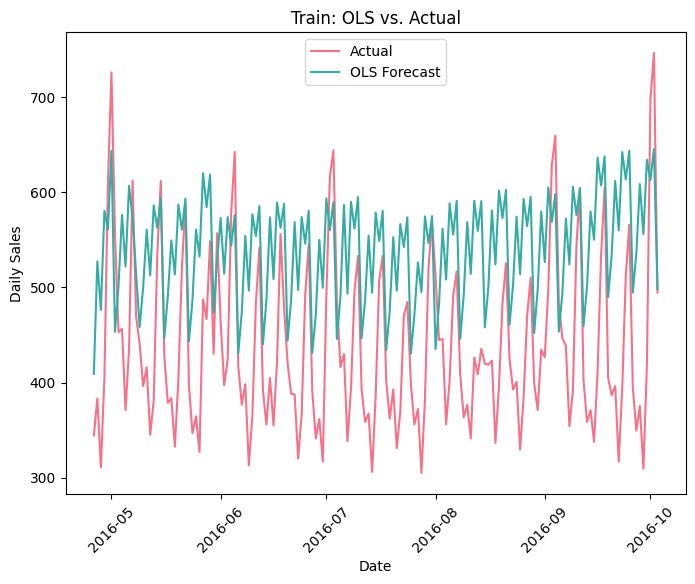

In [186]:
plot_predictions(val_data['date'],y_val_ols, val_ols_predictions, 'OLS Forecast', 'Train: OLS vs. Actual') #need toconvert series to dfs

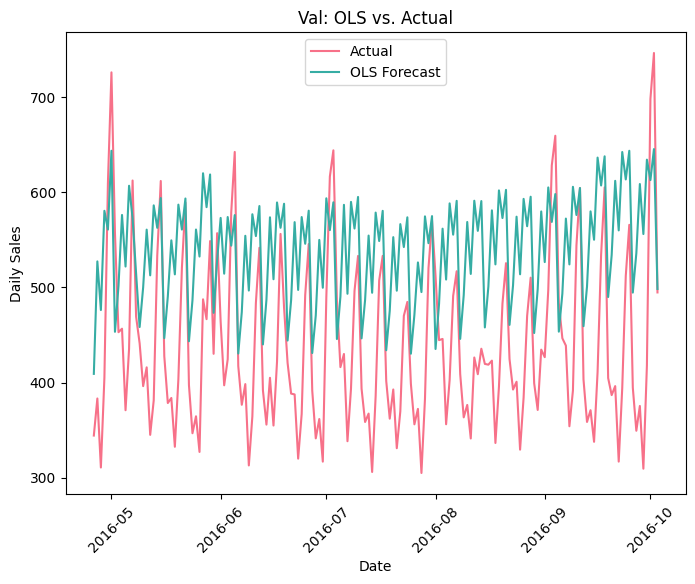

In [187]:
plot_predictions(val_data['date'],y_val_ols, val_ols_predictions, 'OLS Forecast', 'Val: OLS vs. Actual') #need toconvert series to dfs

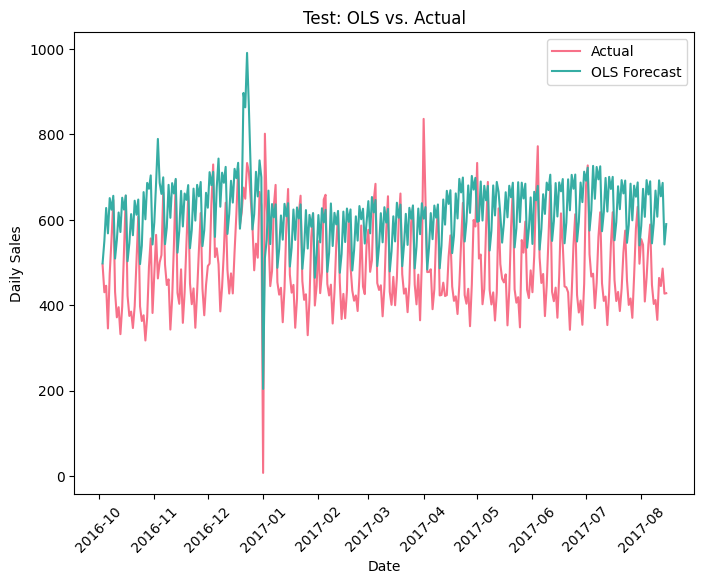

In [188]:
plot_predictions(test_data['date'],y_test_ols, test_ols_predictions, 'OLS Forecast', 'Test: OLS vs. Actual') #need toconvert series to dfs

## OLS with family cluster ##

In [189]:
df_train_ols = create_dummy_fam_cluster(train_data)
df_val_ols = create_dummy_fam_cluster(val_data)
df_test_ols = create_dummy_fam_cluster(test_data)

In [190]:
columns_to_scale =  list(df_train_ols.columns)
columns_to_scale.remove('sales')
columns_to_scale.remove('onpromotion')
columns_to_scale.remove('day_of_week')
columns_to_scale.remove('month')
columns_to_scale.remove('year')
columns_to_scale.remove('oil_price')


In [191]:
df_train_ols = scale_df(df_train_ols, columns_to_scale)
df_val_ols = scale_df(df_val_ols, columns_to_scale)
df_test_ols = scale_df(df_test_ols, columns_to_scale)

In [192]:
X_ols = df_train_ols.drop(columns=['sales'])
# add constant for linear regression

X_ols.insert(0, 'const',1)


#X_ols = sm.add_constant(X_ols)
y_ols = train_data['sales']
y_ols = df_train_ols['sales']

In [193]:
X_val_ols = df_val_ols.drop(columns=['sales'])
# add constant for linear regression
X_val_ols.insert(0, 'const',1)
y_val_ols = df_val_ols['sales']

In [194]:
X_test_ols = df_test_ols.drop(columns=['sales'])
# add constant for linear regression
X_test_ols.insert(0, 'const',1)
y_test_ols = df_test_ols['sales']

In [195]:
model_OLS = sm.OLS(y_ols,X_ols).fit()
model_summary = model_OLS.summary()

In [196]:
# validation metrics
val_ols_predictions = model_OLS.predict(X_val_ols)
ols_metrics = evaluate_forecast(y_val_ols, val_ols_predictions)

ols_metrics

{'MSE': 1103104.4703106869,
 'RMSE': 1050.287803561808,
 'RMSLE': 3.286113202863353}

In [197]:
# test metrics
test_ols_predictions = model_OLS.predict(X_test_ols)
ols_metrics_test = evaluate_forecast(y_test_ols, test_ols_predictions)

ols_metrics_test

{'MSE': 1209989.1928554974,
 'RMSE': 1099.995087650621,
 'RMSLE': 3.293953279514322}

In [198]:
train_data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'cluster',
       'day_of_week', 'month', 'year', 'oil_price', 'familycluster',
       'holiday_Carnaval', 'holiday_Dia de la Madre',
       'holiday_Dia del Trabajo', 'holiday_Fundacion de Quito',
       'holiday_Independencia de Cuenca',
       'holiday_Mundial de futbol Brasil: Ecuador-Suiza', 'holiday_Navidad-1',
       'holiday_Navidad-2', 'holiday_Navidad-3', 'holiday_Navidad-4',
       'holiday_Primer dia del ano', 'holiday_Terremoto Manabi+1',
       'holiday_Terremoto Manabi+2', 'holiday_Terremoto Manabi+3',
       'holiday_Terremoto Manabi+4', 'holiday_Terremoto Manabi+5',
       'holiday_Traslado Primer dia del ano'],
      dtype='object')

In [199]:
train_data['date'].max()

Timestamp('2016-04-26 00:00:00')

In [200]:
#shorten train for testing
train_data_sarima = train_data[train_data['date']>'2016-04-01']

In [201]:
train_data_sarima = train_data[['date','cluster','familycluster','sales']]

In [202]:
#train_data_sarima = train_data_s[train_data_s['date']=='2015-09-01']
#train_data_sarima = train_data_s.set_index('date')
#val_data_sarima = val_data_s.set_index('date')

In [203]:
train_data_sarima_exog = train_data_sarima[['familycluster','cluster']]
y_train_sarima_endog = train_data_sarima['sales']

#val_data_sarima_exog = val_data_sarima[['familycluster','cluster']]
#y_val_sarima_endog = val_data_sarima['sales']